# Create Synthetic Neural Manifolds

### Set-up + Imports

In [1]:
import setup

setup.main()
%load_ext autoreload
%autoreload 2
%load_ext jupyter_black

import neurometry.datasets.synthetic as synthetic
import numpy as np

import matplotlib.pyplot as plt


import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"
import geomstats.backend as gs

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import torch

Working directory:  /home/facosta/neurometry/neurometry
Directory added to path:  /home/facosta/neurometry
Directory added to path:  /home/facosta/neurometry/neurometry


INFO:root:Using pytorch backend


set random seed

In [23]:
g_cpu = torch.Generator()
g_cpu.manual_seed(2147483647);

### Plot circle $\mathcal{S}^1$ and $N=3$ encoding vectors



We will project latent manifold $\mathcal{S}^1$ (minimal embedding dimension $d=2$) into $N$-dimensional neural state space ($N=3$) with a $d\times N$ matrix $A$. The entries of $A$ are randomly sampled from a uniform distribution $U[-1,1]$ and its columns are random encoding vectors. 

Generate points on task manifold (`task_points`) and neural manifold points (`noisy_points`, `manifold_points`):

In [24]:
task_points = synthetic.hypersphere(1, 1000)
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=task_points,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array([5, 3, 1]),
)

Plot:

In [25]:
num_points = 1000
x = task_points[:, 0]
y = task_points[:, 1]
z = np.zeros(num_points)

angles = torch.atan2(task_points[:, 1], task_points[:, 0])
normalized_angles = angles / (2 * np.pi) + 1 / 2
colors = plt.cm.hsv(normalized_angles)

N = 3
place_angles = np.linspace(0, 2 * np.pi, N, endpoint=False)
encoding_matrix = gs.vstack((gs.cos(place_angles), gs.sin(place_angles)))
vectors = [encoding_matrix[:, i] for i in range(N)]

cm = plt.get_cmap("twilight")
vector_colors = [cm(1.0 * i / N) for i in range(N)]
vector_colors = [
    "rgb({}, {}, {})".format(int(r * 255), int(g * 255), int(b * 255))
    for r, g, b, _ in vector_colors
]

scatter1 = go.Scatter3d(
    x=x, y=y, z=z, mode="markers", marker=dict(size=5, color=colors), name="Data Points"
)

lines_and_cones = []
for idx, (vector, color) in enumerate(zip(vectors, vector_colors)):
    lines_and_cones.append(
        go.Scatter3d(
            x=[0, vector[0]],
            y=[0, vector[1]],
            z=[0, 0],
            mode="lines",
            line=dict(color=color, width=5),
            name=f"Encoding Vector {idx+1}",
        )
    )
    lines_and_cones.append(
        go.Cone(
            x=[vector[0]],
            y=[vector[1]],
            z=[0],
            u=[vector[0] / 10],
            v=[vector[1] / 10],
            w=[0],
            showscale=False,
            colorscale=[[0, color], [1, color]],
            sizemode="absolute",
            sizeref=0.1,
        )
    )


x = noisy_points[:, 0]
y = noisy_points[:, 1]
z = noisy_points[:, 2]

print(f"mean firing rate: {torch.mean(noisy_points):.2f} Hz")

scatter2 = go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode="markers",
    marker=dict(size=5, color=colors),
    name="Neural activations",
)


fig = make_subplots(
    rows=1, cols=2, specs=[[{"type": "scatter3d"}, {"type": "scatter3d"}]]
)

# Add the first set of traces (scatter1 and lines_and_cones) to the first subplot
fig.add_traces(
    [scatter1] + lines_and_cones,
    rows=[1] * (len([scatter1]) + len(lines_and_cones)),
    cols=[1] * (len([scatter1]) + len(lines_and_cones)),
)

# Add the second scatter (scatter2) to the second subplot
fig.add_trace(scatter2, row=1, col=2)

reference_frequency = 200


fig.update_layout(
    scene1=dict(
        aspectmode="cube",
        xaxis=dict(range=[-1.2, 1.2], title="Feature 1"),
        yaxis=dict(range=[-1.2, 1.2], title="Feature 2"),
        zaxis=dict(range=[-1.2, 1.2], title=""),
    ),
    scene2=dict(
        aspectmode="cube",
        xaxis=dict(
            range=[-reference_frequency * 1.2, reference_frequency * 1.2],
            title="Neuron 1 firing rate",
        ),
        yaxis=dict(
            range=[-reference_frequency * 1.2, reference_frequency * 1.2],
            title="Neuron 2 firing rate",
        ),
        zaxis=dict(
            range=[-reference_frequency * 1.2, reference_frequency * 1.2],
            title="Neuron 3 firing rate",
        ),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    title_text="",
    annotations=[
        dict(
            text="Feature Space",
            xref="paper",
            yref="paper",
            x=0.25,
            y=0.95,
            showarrow=False,
            font=dict(size=20),
        ),
        dict(
            text="Neural Space",
            xref="paper",
            yref="paper",
            x=0.75,
            y=0.95,
            showarrow=False,
            font=dict(size=20),
        ),
    ],
)

fig.show()

mean firing rate: 100.17 Hz


Plot neuron tuning curves:

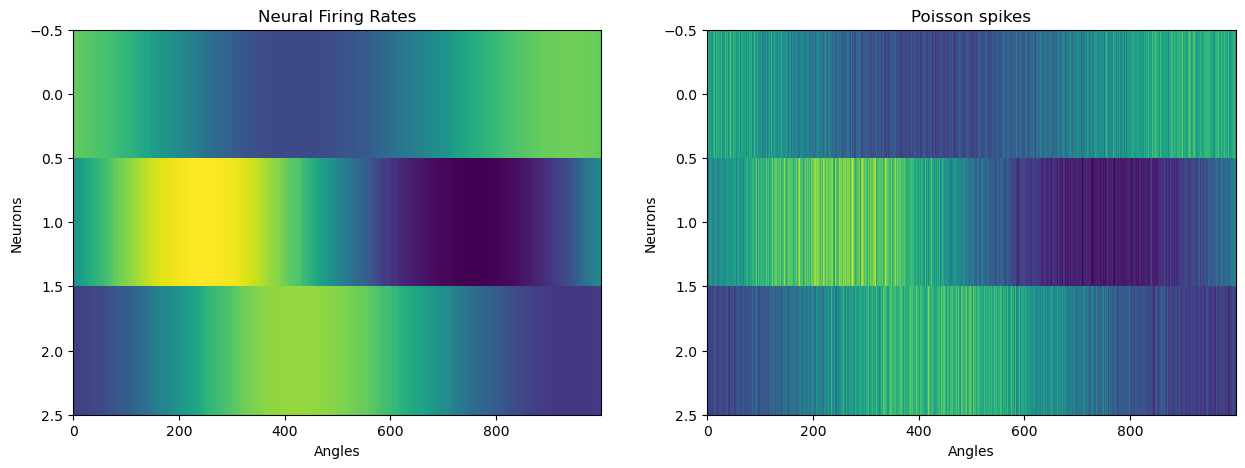

In [21]:
sorted_indices = torch.argsort(angles)
sorted_data_by_angles = manifold_points[sorted_indices, :]

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
axs[0].imshow(sorted_data_by_angles.T, aspect="auto", interpolation="none")
axs[0].set_xlabel("Angles")
axs[0].set_ylabel("Neurons")
axs[0].set_title("Neural Firing Rates")

sorted_noisy_data_by_angles = noisy_points[sorted_indices, :]

axs[1].imshow(sorted_noisy_data_by_angles.T, aspect="auto", interpolation="none")
axs[1].set_xlabel("Angles")
axs[1].set_ylabel("Neurons")
axs[1].set_title("Poisson spikes");

### Visualize cylinder ($\mathcal{S}^1 \times [0,1]$)

In [423]:
cylinder_points = synthetic.cylinder(num_points)

x = cylinder_points[:, 0]
y = cylinder_points[:, 1]
z = cylinder_points[:, 2]

scatter = go.Scatter3d(x=x, y=y, z=z, mode="markers", marker=dict(size=5))


fig = go.Figure(data=[scatter])

fig.update_layout(
    title={
        "text": "Cylinder",
        "y": 0.5,
        "x": 0.1,
        "xanchor": "center",
        "yanchor": "top",
        "font": dict(size=25),
    },
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-1.2, 1.2], title="Feature 1"),
        yaxis=dict(range=[-1.2, 1.2], title="Feature 2"),
        zaxis=dict(range=[-1.2, 1.2], title="Feature 3"),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

fig.show()

### Encode 2-dim Flat torus in $N$-dimensional neural state space (N=3).

In [469]:
num_points = 1000

torus_points = synthetic.hypertorus(2, num_points, radii=[1, 1])

N = 3

encoding_matrix = synthetic.random_encoding_matrix(4, N)

encoded_data = synthetic.encode_points(torus_points, encoding_matrix)

scales = 2 * gs.ones(N)

sigmoid_data = synthetic.apply_nonlinearity(encoded_data, "sigmoid", scales=scales)


x = sigmoid_data[:, 0]
y = sigmoid_data[:, 1]
z = sigmoid_data[:, 2]


scatter = go.Scatter3d(x=x, y=y, z=z, mode="markers", marker=dict(size=5))


fig = go.Figure(data=[scatter])

fig.update_layout(
    title={
        "text": "Torus",
        "y": 0.5,
        "x": 0.1,
        "xanchor": "center",
        "yanchor": "top",
        "font": dict(size=25),
    },
    scene=dict(
        aspectmode="cube",
        xaxis=dict(range=[-1.2, 1.2], title="Feature 1"),
        yaxis=dict(range=[-1.2, 1.2], title="Feature 2"),
        zaxis=dict(range=[-1.2, 1.2], title="Feature 3"),
    ),
    margin=dict(l=0, r=0, b=0, t=0),
)

fig.show()

## Extrinsic dimension of curved low-dim manifold

Text(0.5, 1.0, 'Estimated Dimension vs. Number of Neurons')

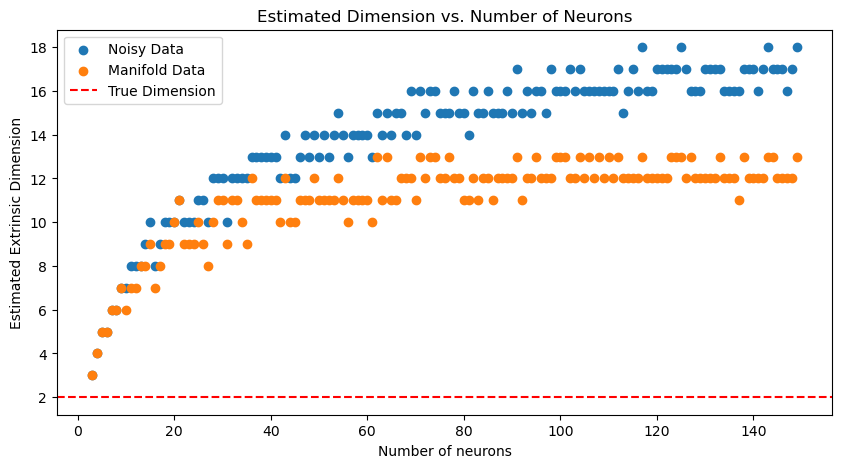

In [93]:
import skdim


num_points = 5000

circle_points = synthetic.hypersphere(1, num_points)


def f(points):
    thetas = gs.arctan2(points[:, 1], points[:, 0])
    amplitudes = 1 + 0.6 * np.cos(12 * thetas)

    return amplitudes.unsqueeze(-1) * points


transformed_circle_points = f(circle_points)

Ns = list(range(3, 150))

noisy_dim_estimates = []
manifold_dim_estimates = []

for N in Ns:
    scales = gs.abs(gs.random.normal(4, 2, N))
    noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
        transformed_circle_points, N, "tanh", poisson_multiplier=10, scales=scales
    )
    noisy_lpca = skdim.id.lPCA(ver="ratio", alphaRatio=0.999).fit(noisy_points)
    manifold_lpca = skdim.id.lPCA(ver="ratio", alphaRatio=0.999).fit(manifold_points)
    noisy_dim_estimates.append(noisy_lpca.dimension_)
    manifold_dim_estimates.append(manifold_lpca.dimension_)

    if N == 3:
        # make 3d plot with plotly
        fig = go.Figure()
        fig.add_trace(
            go.Scatter3d(
                x=manifold_points[:, 0],
                y=manifold_points[:, 1],
                z=manifold_points[:, 2],
                mode="markers",
                marker=dict(size=5),
                name="3d neural space",
            )
        )
        fig.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(Ns, noisy_dim_estimates, label="Noisy Data")
ax.scatter(Ns, manifold_dim_estimates, label="Manifold Data")
ax.axhline(y=2, color="r", linestyle="--", label="True Dimension")

ax.legend()
ax.set_xlabel("Number of neurons")
ax.set_ylabel("Estimated Extrinsic Dimension")
ax.set_title("Estimated Dimension vs. Number of Neurons")
# ax.set_xlim([3, Ns[-1]])
# ax.set_ylim([0, Ns[-1]]);

In [96]:
np.sqrt(1 / 2000) * 100

2.23606797749979

## Synthetic neural activity encoding Van der Pol Oscillator

In [10]:
def runge_kutta_4(g_1, g_2, kappa_1_0, kappa_2_0, t_0, t_n, h):
    t_values = np.arange(t_0, t_n + h, h)
    kappa_1_values = []
    kappa_2_values = []

    kappa_1 = kappa_1_0
    kappa_2 = kappa_2_0

    for t in t_values:
        kappa_1_values.append(kappa_1)
        kappa_2_values.append(kappa_2)

        k1_1 = h * g_1(kappa_1, kappa_2, t)
        k1_2 = h * g_2(kappa_1, kappa_2, t)

        k2_1 = h * g_1(kappa_1 + 0.5 * k1_1, kappa_2 + 0.5 * k1_2, t)
        k2_2 = h * g_2(kappa_1 + 0.5 * k1_1, kappa_2 + 0.5 * k1_2, t)

        k3_1 = h * g_1(kappa_1 + 0.5 * k2_1, kappa_2 + 0.5 * k2_2, t)
        k3_2 = h * g_2(kappa_1 + 0.5 * k2_1, kappa_2 + 0.5 * k2_2, t)

        k4_1 = h * g_1(kappa_1 + k3_1, kappa_2 + k3_2, t)
        k4_2 = h * g_2(kappa_1 + k3_1, kappa_2 + k3_2, t)

        kappa_1 += (1 / 6) * (k1_1 + 2 * k2_1 + 2 * k3_1 + k4_1)
        kappa_2 += (1 / 6) * (k1_2 + 2 * k2_2 + 2 * k3_2 + k4_2)

    return t_values, kappa_1_values, kappa_2_values

In [25]:
def g_1(kappa_1, kappa_2, t):
    return kappa_2


mu = 0.4


def g_2(kappa_1, kappa_2, t):
    return -kappa_1 + mu * (1 - kappa_1**2) * kappa_2

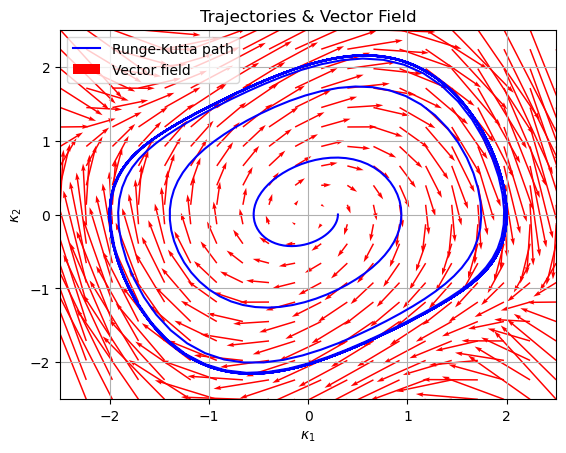

In [39]:
t_0, t_n = 0, 100
h = 0.1


plt.figure()
plt.legend()
plt.xlabel("$\kappa_1$")
plt.ylabel("$\kappa_2$")
plt.title("Trajectories & Vector Field")

# plt.quiver(X, Y, U, V, scale=20, color="r", label="Vector field")

kappa_1_0, kappa_2_0 = 0.3, 0
t_values, kappa_1_values, kappa_2_values = runge_kutta_4(
    g_1, g_2, kappa_1_0, kappa_2_0, t_0, t_n, h
)
plt.plot(kappa_1_values, kappa_2_values, "b-", label="Runge-Kutta path")
plt.xlim((-2.5, 2.5))
plt.ylim((-2.5, 2.5))
# show gridlines
plt.grid(True)

x_min, x_max = -2.5, 2.5
y_min, y_max = -2.5, 2.5


x_range = np.linspace(x_min, x_max, 20)
y_range = np.linspace(y_min, y_max, 20)
t_range = np.linspace(0, 2 * np.pi, 20)

X, Y = np.meshgrid(x_range, y_range)
U = g_1(X, Y, 0)
V = g_2(X, Y, 0)
plt.quiver(X, Y, U, V, scale=20, color="r", label="Vector field")
plt.legend();

In [40]:
# make a np array of shape (num_points, 2) from the lists kappa_1_values and kappa_2_values

kappa_values = np.array([kappa_1_values, kappa_2_values]).T

In [44]:
noisy_points, manifold_points = synthetic.synthetic_neural_manifold(
    points=kappa_values,
    encoding_dim=3,
    nonlinearity="sigmoid",
    scales=gs.array([5, 3, 1]),
)

noise level: 7.07%


In [45]:
# make 3d plot with plotly of the noisy points

# x = noisy_points[:, 0]
# y = noisy_points[:, 1]
# z = noisy_points[:, 2]

x = manifold_points[:, 0]
y = manifold_points[:, 1]
z = manifold_points[:, 2]

scatter = go.Scatter3d(x=x, y=y, z=z, mode="markers", marker=dict(size=5))

fig = go.Figure(data=[scatter])

fig.update_layout(
    title={
        "text": "Noisy Neural Activations",
        "y": 0.5,
        "x": 0.1,
        "xanchor": "center",
        "yanchor": "top",
        "font": dict(size=25),
    },
    # scene=dict(
    #     aspectmode="cube",
    #     xaxis=dict(range=[-1.2, 1.2], title="Feature 1"),
    #     yaxis=dict(range=[-1.2, 1.2], title="Feature 2"),
    #     zaxis=dict(range=[-1.2, 1.2], title="Feature 3"),
    # ),
    margin=dict(l=0, r=0, b=0, t=0),
)

fig.show()

In [50]:
from gtda.homology import WeakAlphaPersistence, VietorisRipsPersistence
from gtda.diagrams import PairwiseDistance
from gtda.plotting import plot_diagram, plot_heatmap
import neurometry.datasets.synthetic as synthetic
import time

homology_dimensions = (
    0,
    1,
    2,
)
VR = VietorisRipsPersistence(
    metric="cosine", homology_dimensions=homology_dimensions, coeff=47
)


gtda_start = time.time()
gtda_vr_diagrams = VR.fit_transform([manifold_points])
gtda_end = time.time()
print(
    f"Time to compute Vietoris-Rips persistence diagrams in giotto-tda: {gtda_end - gtda_start:.2f}"
)


fig = plot_diagram(
    gtda_vr_diagrams[-1],
    plotly_params={
        "title": "Vietoris-Rips Persistence Diagram, Van der Pol Oscillator"
    },
)
fig.update_layout(title="Vietoris-Rips Persistence Diagram, Van der Pol Oscillator")

Time to compute Vietoris-Rips persistence diagrams in giotto-tda: 20.90


In [49]:
from gtda.homology import WeightedRipsPersistence

homology_dimensions = (
    0,
    1,
    2,
)

WR = WeightedRipsPersistence(
    metric="cosine", homology_dimensions=homology_dimensions, coeff=47
)

gtda_start = time.time()

gtda_wr_diagrams = WR.fit_transform([manifold_points])
gtda_end = time.time()

print(
    f"Time to compute Weighted-Rips persistence diagrams in giotto-tda: {gtda_end - gtda_start:.2f}"
)

fig = plot_diagram(
    gtda_wr_diagrams[-1],
    plotly_params={
        "title": "Weighted-Rips Persistence Diagram, Van der Pol Oscillator"
    },
)

fig.update_layout(title="Weighted-Rips Persistence Diagram, Van der Pol Oscillator")

Time to compute Weighted-Rips persistence diagrams in giotto-tda: 20.80
